In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
df = pd.read_csv('rideshare_kaggle.csv')

Исследуемый датасет содержит в себе данные о поездках пользователей в Uber и Lyft в городе Бостон, с подробным описанием погоды во время каждого заказа. Попробуем обучить модели, которые предсказывали бы цену

In [2]:
df.head(5)

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


#### 1. EDA

In [3]:
print("DataFrame shape " + str(df.shape))

DataFrame shape (693071, 57)


Вначале уберем избыточные данные и посмотрим корреляционные зависимости

In [4]:
# Уберем очевидно избыточные колонки
df.drop(['timestamp', 'datetime', 'timezone', 'cab_type', 'product_id', 'latitude', 'longitude', 'long_summary'], axis=1, inplace=True)

# Уберем столбцы с излишней корреляцией
corrs = df.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.94)]

print("Колонки на удаление: " + str(cols_to_drop))
df.drop(cols_to_drop, axis=1, inplace=True)
df.head(5)

# Уберем записи, не имеющие значения цены (50000 записей из примерно 600000)
# df.isna().sum()
df.dropna(inplace=True)

['apparentTemperature', 'temperatureHighTime', 'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime', 'apparentTemperatureLowTime', 'visibility.1', 'sunriseTime', 'sunsetTime', 'uvIndexTime', 'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 'apparentTemperatureMin', 'apparentTemperatureMinTime', 'apparentTemperatureMax', 'apparentTemperatureMaxTime']


<AxesSubplot: >

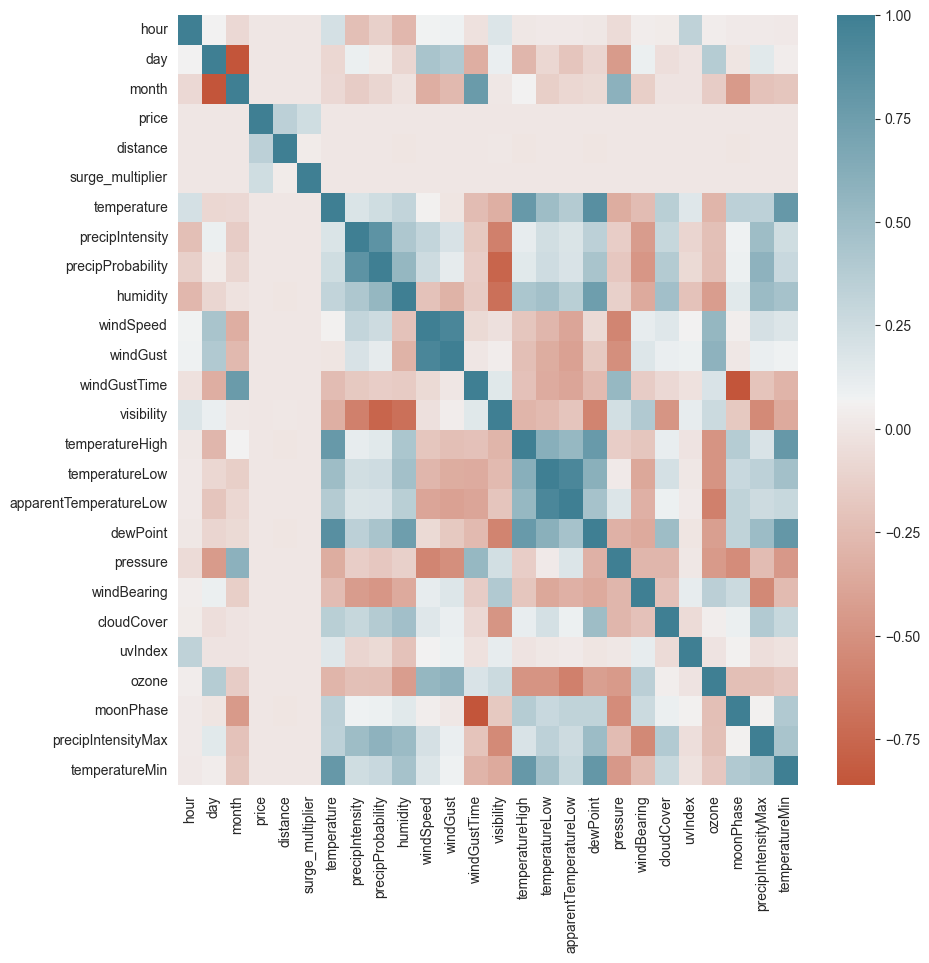

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, as_cmap=True))

Интересно, что практически все столбцы почти не коррелируют с ценой и модификатором цены. Попробуем создать модели линейной регрессии, которая бы предсказывали цену и множитель цены, исходя из погодных условий

Сохраним таблицу для дальнейшей обработки

In [6]:
df.to_csv('huh.csv')